# HW1 Q2 - Convolutional Neural Networks

In this question we set up a CNN with a similar number of parameters as in the multilayer perceptron in Q1.

First, we import some PyTorch libraries and direct them to use Google Colab's GPU:

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

from torch.autograd import Variable

In [0]:
# Use the GPU
device = torch.device('cuda')

Next, we import the MNIST training and testing data, which is an included dataset in the `torchvision` library.

In [3]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# We could chain transforms together here
transform = transforms.ToTensor()

# Import the training set into the mnist/ dir
mnist_train = datasets.MNIST(root='./mnist', train=True,
                            download=True,
                            transform=transform)

# Import the test set too
mnist_test = datasets.MNIST(root='./mnist', train=False,
                           download=True,
                           transform=transform)

Processing...
Done!


To split the training data into a training and validation set, we need to establish a `sampler` for each that will pull out certain samples when called from the dataloader. In our case, we have a 15% validation split, with 51000 training examples and 9000 validation examples.

In [0]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# Fix seed
np.random.seed(42)
torch.manual_seed(42)

# Define samplers for the data (to get validation split)
num_train_samples = 51000
train_sampler = SubsetRandomSampler(np.arange(num_train_samples, 
                                              dtype=np.int64))

num_valid_samples = 9000
valid_sampler = SubsetRandomSampler(np.arange(num_train_samples,
                                             num_train_samples + num_valid_samples,
                                             dtype=np.int64))

num_test_samples = 10000
test_sampler = SubsetRandomSampler(np.arange(num_test_samples,
                                            dtype=np.int64))

And we set our hyperparameters and other useful constants:

In [0]:
batch_size = 32
learning_rate = 0.01
num_epochs = 20

num_classes = 10

As a last step before training, we define training, validation, and test dataloaders that sample from the above `sampler`s according to the defined batch size:

In [0]:
# Get dataloaders for train/valid/test
train_loader = torch.utils.data.DataLoader(mnist_train,
                                          batch_size=batch_size,
                                          sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(mnist_train,
                                          batch_size=batch_size,
                                          sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(mnist_test,
                                         batch_size=batch_size,
                                         sampler=test_sampler)

## CNN architecture definition

Now we define the class for our CNN.

In [0]:
# Define the CNN class

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    self.conv2 = nn.Conv2d(18, 64, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    self.fc1 = nn.Linear(64*7*7, 175)
    self.fc2 = nn.Linear(175, 10)
    
  def forward(self, x):
    #print('Input: ', x.size())
    x = F.relu(self.conv1(x))
    #print('After relu: ', x.size())
    x = self.pool1(x)
    #print('After pool: ', x.size())
    x = F.relu(self.conv2(x))
    #print('After relu conv2: ', x.size())
    x = self.pool2(x)
    #print('After pool: ', x.size())
    x = x.view(-1, 64*7*7)
    #print('After view: ', x.size())
    x = F.relu(self.fc1(x))
    #print('After relu: ', x.size())
    x = self.fc2(x)
    #print('After fully connected: ', x.size())
    return x
    

This CNN has two convolutional layers, each with a ReLU activation, a kernel size of 3, a stride of 1, and a padding level of 1. The first convolutional layer learns 18 feature maps and the second learns 64 feature maps. Both convolutional layers use max pooling after their operation, with a kernel size of 2 and stride of 2.

Finally, the data will pass through two fully connected layers and output to 10 units representing our 10 possible digit classes.

Below, we see an outline of this architecture. Note that the total number of trainable parameters is between 0.5 and 1 million.

In [8]:
model = CNN().to(device)
print(model)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters: {}'.format(params))

CNN(
  (conv1): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(18, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=175, bias=True)
  (fc2): Linear(in_features=175, out_features=10, bias=True)
)
Number of parameters: 561347


## CNN training

Now we will define our loss function and stochastic gradient descent optimizer, and run over the training loop for our CNN.

In [0]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# Make a nice progress bar - tqdm on colab is a bit buggy though
from tqdm import tqdm

# Train and validate
print('\nBeginning training.')
total_step = len(train_loader)
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  running_train_loss, running_valid_loss = 0.0, 0.0 # Losses restart at the epoch
  train_total, valid_total = 0, 0
  train_correct, valid_correct = 0, 0
  
  model.train()
  # Training set
  for i, (images, labels) in enumerate(tqdm(train_loader, position=0)):
    images, labels = images.to(device),labels.to(device)
    optimizer.zero_grad()
    
    # Forward
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_train_loss += loss.item()
    
    # Backward
    loss.backward()
    optimizer.step()
    
    # Track loss and accuracy
    train_total += labels.size(0)
    _, train_predicted = torch.max(outputs.data, 1)
    train_correct += (train_predicted == labels).sum().item()
    train_acc = train_correct/train_total
  
  model.eval()
  # Validation set
  for images, labels in valid_loader:
    images, labels = images.to(device), labels.to(device)
    valid_outputs = model(images)
    valid_loss = criterion(valid_outputs, labels)
    running_valid_loss += valid_loss.item()
    valid_total += labels.size(0)
    _, valid_predicted = torch.max(valid_outputs.data, 1)
    valid_correct += (valid_predicted == labels).sum().item()
    valid_acc = valid_correct/valid_total
  
  train_losses.append(running_train_loss)
  train_accuracies.append(train_acc)
  valid_losses.append(running_valid_loss)
  valid_accuracies.append(valid_acc)
  # Mod this when num epochs is too big
  print('\ntrain_loss: {}, train_acc: {}, valid_loss: {}, valid_acc: {}'.format(
      running_train_loss, train_acc*100, running_valid_loss, valid_acc*100))

  0%|          | 2/1594 [00:00<01:24, 18.74it/s]


Beginning training.
Epoch 1/20


  1%|          | 12/1594 [00:00<00:13, 115.98it/s]


train_loss: 1332.2324795424938, train_acc: 74.73333333333333, valid_loss: 70.24751602858305, valid_acc: 92.25555555555556
Epoch 2/20


  1%|          | 12/1594 [00:00<00:13, 119.35it/s]


train_loss: 354.126238103956, train_acc: 93.17450980392157, valid_loss: 38.98537100106478, valid_acc: 95.89999999999999
Epoch 3/20


  1%|          | 12/1594 [00:00<00:13, 116.14it/s]


train_loss: 227.07753149420023, train_acc: 95.65098039215685, valid_loss: 37.89683987945318, valid_acc: 95.97777777777777
Epoch 4/20


  1%|          | 12/1594 [00:00<00:13, 115.96it/s]


train_loss: 171.61356449127197, train_acc: 96.63137254901962, valid_loss: 24.09066040813923, valid_acc: 97.45555555555555
Epoch 5/20


  1%|          | 12/1594 [00:00<00:13, 115.82it/s]


train_loss: 137.78825823962688, train_acc: 97.32745098039216, valid_loss: 20.795971490442753, valid_acc: 97.7
Epoch 6/20


  1%|          | 12/1594 [00:00<00:13, 116.42it/s]


train_loss: 117.12419238686562, train_acc: 97.68039215686275, valid_loss: 18.14135928452015, valid_acc: 98.32222222222222
Epoch 7/20


  1%|          | 12/1594 [00:00<00:13, 114.73it/s]


train_loss: 103.30317091010511, train_acc: 97.99215686274509, valid_loss: 18.48393912613392, valid_acc: 98.06666666666666
Epoch 8/20


  1%|          | 12/1594 [00:00<00:13, 115.39it/s]


train_loss: 90.46443284209818, train_acc: 98.22745098039216, valid_loss: 16.563708625733852, valid_acc: 98.45555555555555
Epoch 9/20


  1%|          | 11/1594 [00:00<00:14, 109.94it/s]


train_loss: 81.40887488797307, train_acc: 98.38823529411765, valid_loss: 17.348023898899555, valid_acc: 98.1
Epoch 10/20


  1%|          | 12/1594 [00:00<00:13, 115.91it/s]


train_loss: 74.28619233891368, train_acc: 98.54705882352941, valid_loss: 17.73153457790613, valid_acc: 98.26666666666667
Epoch 11/20


  1%|          | 12/1594 [00:00<00:13, 115.90it/s]


train_loss: 67.05339493742213, train_acc: 98.68823529411765, valid_loss: 15.416800022125244, valid_acc: 98.44444444444444
Epoch 12/20


  1%|          | 12/1594 [00:00<00:13, 116.86it/s]


train_loss: 61.855515753268264, train_acc: 98.7607843137255, valid_loss: 13.626686088740826, valid_acc: 98.55555555555556
Epoch 13/20


  1%|          | 12/1594 [00:00<00:13, 115.97it/s]


train_loss: 57.12211852520704, train_acc: 98.83529411764705, valid_loss: 14.965608030557632, valid_acc: 98.5
Epoch 14/20


  1%|          | 12/1594 [00:00<00:14, 111.88it/s]


train_loss: 52.228462438099086, train_acc: 98.96666666666667, valid_loss: 16.246120758354664, valid_acc: 98.3
Epoch 15/20


  1%|          | 12/1594 [00:00<00:13, 116.97it/s]


train_loss: 49.495644966722466, train_acc: 99.04117647058823, valid_loss: 14.384172715246677, valid_acc: 98.65555555555555
Epoch 16/20


  1%|          | 12/1594 [00:00<00:13, 114.60it/s]


train_loss: 44.35758112859912, train_acc: 99.12352941176471, valid_loss: 13.95925435423851, valid_acc: 98.64444444444445
Epoch 17/20


  1%|          | 12/1594 [00:00<00:13, 116.88it/s]


train_loss: 40.756848665419966, train_acc: 99.2156862745098, valid_loss: 13.244053438305855, valid_acc: 98.66666666666667
Epoch 18/20


  1%|          | 12/1594 [00:00<00:13, 116.16it/s]


train_loss: 38.18021708726883, train_acc: 99.24313725490195, valid_loss: 14.322460010647774, valid_acc: 98.55555555555556
Epoch 19/20


  1%|          | 11/1594 [00:00<00:14, 109.43it/s]


train_loss: 36.08296651637647, train_acc: 99.25882352941177, valid_loss: 13.428653441369534, valid_acc: 98.8
Epoch 20/20


100%|██████████| 1594/1594 [00:13<00:00, 115.36it/s]



train_loss: 32.71211145320558, train_acc: 99.40980392156862, valid_loss: 12.740328028798103, valid_acc: 98.82222222222222


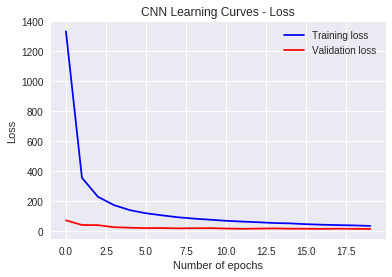

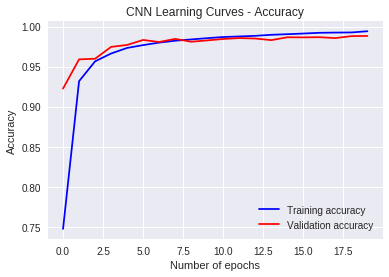

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title('CNN Learning Curves - Loss')
plt.plot(range(num_epochs), train_losses, color='blue', label='Training loss')
plt.plot(range(num_epochs), valid_losses, color='red', label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('CNN Learning Curves - Accuracy')
plt.plot(range(num_epochs), train_accuracies, color='blue', label='Training accuracy')
plt.plot(range(num_epochs), valid_accuracies, color='red', label='Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CNN Testing

Now we evaluate the test performance of our CNN.

In [13]:
# Test the model
model.eval()

with torch.no_grad():
  total, correct = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    test_loss = criterion(outputs, labels)
    total += labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    test_acc = correct/total

print('Beginning testing.')
print('Loss: {}, accuracy: {}'.format(test_loss, test_acc*100))

Beginning testing.
Loss: 0.0006119012832641602, accuracy: 98.96000000000001


# Comparison with Q1

While the MLP in Q1 was able to achieve 99.96% training accuracy and 97.02% validation accuracy, it took a significantly longer time to train (on the order of hours, while the CNN takes on the order of seconds). This speedup is certainly due to the use of GPUs made possible by PyTorch's architecture, which vanilla Numpy does not support.

This CNN was able to surpass the MLP in validation accuracy, achieving and 99.82%. This is likely due to the fact that due to the convolution operation, the CNN is allowed to preserve and explore much of the substructure in the images than a vanilla MLP which must flatten the whole image array. Also notable is the fact that CNN training was able to reach these accuracies after only 20 epochs, and had surpassed the MLP's performance within 10, while the MLP took 35 epochs. This indicates that while convolution is a more complex operation, it is capable of processing and learning more information more densely over time than a vanilla MLP.